## 🌐 **Google Drive Connection**

In [81]:
# Install and configure Kaggle API
!pip install -q kaggle

from google.colab import files
print("Carica il file kaggle.json (scaricabile dal tuo profilo Kaggle)")
files.upload()  # select kaggle.json from your pc, using the API from user->setting in KAGGLE (create new token)

# Configura le credenziali
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Monta Google Drive
from google.colab import drive
drive.mount("/gdrive")

# Percorso di destinazione sul Drive
dataset_path = "/gdrive/MyDrive/Artificial_Neural_Networks/Timeseries_Classification_Challenge/dataset"
!mkdir -p {dataset_path}

# Scarica il dataset direttamente da Kaggle nella cartella scelta
!kaggle competitions download -c an2dl2526c1 -p {dataset_path}

# Decomprimi (opzionale, solo se i file sono .zip)
!unzip -o {dataset_path}/an2dl2526c1.zip -d {dataset_path}

print(f"Dataset scaricato e disponibile in: {dataset_path}")


Carica il file kaggle.json (scaricabile dal tuo profilo Kaggle)


Saving kaggle.json to kaggle.json
Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
an2dl2526c1.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  /gdrive/MyDrive/Artificial_Neural_Networks/Timeseries_Classification_Challenge/dataset/an2dl2526c1.zip
  inflating: /gdrive/MyDrive/Artificial_Neural_Networks/Timeseries_Classification_Challenge/dataset/pirate_pain_test.csv  
  inflating: /gdrive/MyDrive/Artificial_Neural_Networks/Timeseries_Classification_Challenge/dataset/pirate_pain_train.csv  
  inflating: /gdrive/MyDrive/Artificial_Neural_Networks/Timeseries_Classification_Challenge/dataset/pirate_pain_train_labels.csv  
  inflating: /gdrive/MyDrive/Artificial_Neural_Networks/Timeseries_Classification_Challenge/dataset/sample_submission.csv  
Dataset scaricato e disponibile in: /gdrive/MyDrive/Artificial_Neural_Networks/Timeseries_Classification_Challenge/dataset


## ⚙️ **Libraries Import**

In [ ]:
# Set seed for reproducibility
SEED = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Profiling library
!pip install -U ydata-profiling
from ydata_profiling import ProfileReport

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(SEED)
random.seed(SEED)

# Import PyTorch
import torch
torch.manual_seed(SEED)
from torch import nn
# from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import TensorDataset, DataLoader
logs_dir = "tensorboard"
!pkill -f tensorboard
%load_ext tensorboard
!mkdir -p models

if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device("cpu")

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")

# Import other libraries
import copy
import shutil
from itertools import product
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from scipy.stats import skew
from typing import List, Tuple

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
PyTorch version: 2.8.0+cu126
Device: cpu


## ⏳ **Data Loading**

In [44]:
dataset_path = "/gdrive/MyDrive/Artificial_Neural_Networks/Timeseries_Classification_Challenge/dataset"
os.makedirs(dataset_path, exist_ok=True)

competition = "an2dl2526c1"
# file needed
dataset_files = ["pirate_pain_test.csv", "pirate_pain_train.csv", "pirate_pain_train_labels.csv"]

# Download file if not done yet
for fname in dataset_files:
    dest_path = os.path.join(dataset_path, fname)
    if not os.path.exists(dest_path):
        print(f"📥 Downloading {fname} ...")
        !kaggle competitions download -c {competition} -f {fname} -p {dataset_path}
    else:
        print(f"✅ {fname} already exists. Using cached version.")

print("\nAll files ready in:", dataset_path)


✅ pirate_pain_test.csv already exists. Using cached version.
✅ pirate_pain_train.csv already exists. Using cached version.
✅ pirate_pain_train_labels.csv already exists. Using cached version.

All files ready in: /gdrive/MyDrive/Artificial_Neural_Networks/Timeseries_Classification_Challenge/dataset


In [45]:
df_training = pd.read_csv(os.path.join(dataset_path, "pirate_pain_train.csv"))
df_labels = pd.read_csv(os.path.join(dataset_path, "pirate_pain_train_labels.csv"))
df_test = pd.read_csv(os.path.join(dataset_path, "pirate_pain_test.csv"))

## 📈 **Data exploration and profiling**

In [ ]:
data_profile = ProfileReport(df_training, title="Profiling Report")
data_profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


  5%|▌         | 2/40 [00:00<00:09,  3.93it/s]


KeyboardInterrupt: 

In [ ]:
# Visualise the count of time for each label
plt.figure(figsize=(17, 5))
sns.countplot(
    x='label',
    data=df_labels,
    order=df_labels['label'].value_counts().index,
    palette='tab10'
)

# Set the title of the plot
plt.title('Label Time')

# Display the plot
plt.show()

In [ ]:
# Count the time for each pirates
time_for_index = df_training.groupby('sample_index').size()
print('Time step for each pirates:\n', time_for_index.value_counts())

##🪛 **Model + Preprocessing Parameters**

In [46]:
EXPERIMENT_NAME = "test"

# Preprocessing and Model flags
NORMAL_VALIDATION = True # if True the dataset will be splitted into training + validation
K_FOLD = False # If True use k-fold
CLIP_LOG = True
MIN_MAX = True
ROBUST_SCALER = False
DROP_HIGHLY_CORRELATED = False

CORRELATION_THRESHOLD = 0.9 # if DROP_HIGLY_CORRELATED is on, drops all features with correlation > than this threshold

# Cross-validation
K = 1                    # Number of splits (5 and 10 are considered good values)
VAL_PERCENT = 0.2          # Number of users for validation split
TEST_PERCENT = 0         # Number of users for test split

# Training
EPOCHS = 500             # Maximum epochs (increase to improve performance)
PATIENCE = 50            # Early stopping patience (increase to improve performance)
VERBOSE = 10             # Print frequency

# Optimisation
LEARNING_RATE = 1e-3     # Learning rate
BATCH_SIZE = 128         # Batch size
WINDOW_SIZE = 30        # Input window size
STRIDE = 10              # Input stride

# Architecture
HIDDEN_LAYERS = 2        # Hidden layers
HIDDEN_SIZE = 128        # Neurons per layer
RNN_TYPE = 'GRU'         # Type of RNN architecture
BIDIRECTIONAL = False    # Bidirectional RNN

# Regularisation
DROPOUT_RATE = 0.5       # Dropout probability
L1_LAMBDA = 0.001        # L1 penalty
L2_LAMBDA = 0.001        # L2 penalty

# Training utilities
WEIGHTED_LOSS = False

# Final training
FINAL_TRAINING = False
# Num of epochs to sum to the best epochs number in the final training
EPOCHS_VARIATION = 10


#-------------------------------------------------------------------------
# Integrity checks to avoid trubbles
assert not (NORMAL_VALIDATION and K_FOLD), "AssertionError: conflict in the validation method!"
assert not (MIN_MAX and ROBUST_SCALER), "AssertionError: conflict in the regularization method!"
assert (NORMAL_VALIDATION or K_FOLD), "AssertionError: no validation method selected!"
assert (MIN_MAX or ROBUST_SCALER), "AssertionError: no scaling method selected!"


## ⚙️ **Data Preprocessing**

###**Functions**

In [47]:
# @title Clip + Log
# This function is used to change the shape of the distribution

def clip_log(df_train, df_val, features):
    """
    Applica il Clipping (1%-99% quantile) e la trasformazione Log(1+x)
    alle feature con alta asimmetria (skewness), basando le statistiche solo sul training set.
    """
    normal_cols = []
    transformable_cols = []
    extreme_cols = []
    train_stats = {}

    # 1. Calcolo delle statistiche di trasformazione solo sul TRAINING set
    for col in features:
        # Calcolo dell'asimmetria (skew)
        s = skew(df_train[col].dropna())

        # Calcolo dei quantili per il clipping
        q_low = df_train[col].quantile(0.01)
        q_high = df_train[col].quantile(0.99)

        train_stats[col] = {'skew': s, 'q_low': q_low, 'q_high': q_high, 'min': df_train[col].min()}

        # Classificazione delle colonne in base all'asimmetria
        if abs(s) < 2:
            normal_cols.append(col)
        elif 2 <= abs(s) <= 10:
            transformable_cols.append(col)
        else:
            extreme_cols.append(col)

    # 2. Applicazione di Clipping e Log-transform (sia su Train che su Validation)
    cols_to_transform = transformable_cols + extreme_cols
    print(f"Trasformazione applicata a: {cols_to_transform}")

    for col in cols_to_transform:
        stats = train_stats[col]
        m = stats['min']
        q_low = stats['q_low']
        q_high = stats['q_high']

        # Trasformazione del Training Set
        df_train[col] = df_train[col].clip(q_low, q_high)
        df_train[col] = np.log1p(df_train[col] - m + 1e-6)

        # Trasformazione del Validation Set (usando le statistiche del Train)
        if col in df_val.columns:
            df_val[col] = df_val[col].clip(q_low, q_high)
            df_val[col] = np.log1p(df_val[col] - m + 1e-6)

        # Test
        # if col in df_test.columns:
        #     df_test[col] = df_test[col].clip(q_low, q_high)
        #     df_test[col] = np.log1p(df_test[col] - m + 1e-6)

    return df_train, df_val

In [48]:
# @title Clip + Log test

# This function is used to change the shape of the distribution
def clip_log_test(df_test, df_training, numerical_cols):
    """
    Applica il Clipping (1%-99% quantile) e la trasformazione Log(1+x)
    alle feature con alta asimmetria (skewness), basando le statistiche solo sul training set.
    """
    normal_cols = []
    transformable_cols = []
    extreme_cols = []
    train_stats = {}

    # 1. Calcolo delle statistiche di trasformazione solo sul TRAINING set
    for col in numerical_cols:
        # Calcolo dell'asimmetria (skew)
        s = skew(df_training[col].dropna())

        # Calcolo dei quantili per il clipping
        q_low = df_training[col].quantile(0.01)
        q_high = df_training[col].quantile(0.99)

        train_stats[col] = {'skew': s, 'q_low': q_low, 'q_high': q_high, 'min': df_training[col].min()}

        # Classificazione delle colonne in base all'asimmetria
        if abs(s) < 2:
            normal_cols.append(col)
        elif 2 <= abs(s) <= 10:
            transformable_cols.append(col)
        else:
            extreme_cols.append(col)

    # 2. Applicazione di Clipping e Log-transform (sia su Train che su Validation)
    cols_to_transform = transformable_cols + extreme_cols
    print(f"Trasformazione applicata a: {cols_to_transform}")

    for col in cols_to_transform:
        stats = train_stats[col]
        m = stats['min']
        q_low = stats['q_low']
        q_high = stats['q_high']

        # Trasformazione del Training Set
        df_test[col] = df_test[col].clip(q_low, q_high)
        df_test[col] = np.log1p(df_test[col] - m + 1e-6)

    return df_test

In [49]:
 # @title Min-max scaling

def min_max_scaling(df_train: pd.DataFrame, df_val: pd.DataFrame, numerical_cols) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Esegue il Min-Max Scaling su colonne specifiche di df_train e df_val.
    Le statistiche (min/max) vengono calcolate SOLO sul df_train.

    Args:
        df_train (pd.DataFrame): Il DataFrame di training.
        df_val (pd.DataFrame): Il DataFrame di validazione.
        numerical_cols (List[str]): Lista delle colonne numeriche da scalare.

    Returns:
        tuple[pd.DataFrame, pd.DataFrame]: I DataFrame di training e validazione scalati.
    """

    # Compute min/max on training set only
    mins = df_train[numerical_cols].min()
    maxs = df_train[numerical_cols].max()

    # Apply min-max scaling to train/val (and test later)
    for col in numerical_cols:
        df_train[col] = (df_train[col] - mins[col]) / (maxs[col] - mins[col])
        df_val[col] = (df_val[col] - mins[col]) / (maxs[col] - mins[col])

    return df_train, df_val, mins, maxs

In [50]:
# @title Min-max scaling test

def min_max_scaling_test(df_test: pd.DataFrame, df_training: pd.DataFrame, numerical_cols):
  # Compute min/max on entire training set
  global_mins = df_training[numerical_cols].min()
  global_maxs = df_training[numerical_cols].max()

  for col in numerical_cols:
    df_test[col] = (df_test[col] - global_mins[col]) / (global_maxs[col] - global_mins[col])

  return df_test

In [51]:
#  @title Robust scaler

def robust_scaler(df_train: pd.DataFrame, df_val: pd.DataFrame, features) -> tuple[pd.DataFrame, pd.DataFrame]:
  scaler = RobustScaler()
  df_train[features] = scaler.fit_transform(df_train[features])
  df_val[features] = scaler.transform(df_val[features])
  return df_train, df_val

In [52]:
#  @title Robust scaler test

def robust_scaler_test(df_test: pd.DataFrame, numerical_cols) -> pd.DataFrame:
  test_scaler = RobustScaler()
  df_test[numerical_cols] = test_scaler.transform(df_test[numerical_cols])
  return df_test

In [53]:
# @title Drop Higly Correleted Features
def drop_highly_correlated_features(df_train: pd.DataFrame, df_val: pd.DataFrame,
    features, threshold: float = 0.9):
    """
    Identifica ed elimina le feature altamente correlate (basato sulla correlazione
    calcolata SOLO sul training set) da tutti i set di dati.

    Args:
        df_train (pd.DataFrame): Il DataFrame di training.
        df_val (pd.DataFrame): Il DataFrame di validazione.
        features (List[str]): Lista delle colonne da esaminare per la correlazione.
        threshold (float): Soglia di correlazione assoluta oltre la quale una feature viene eliminata.

    Returns:
        Tuple[pd.DataFrame, pd.DataFrame]: I DataFrame di training e validazione con le colonne eliminate.
    """

    print(f"--- Inizio controllo correlazione (Soglia: {threshold}) ---")

    # Calcola la matrice di correlazione assoluta SOLO sul Training Set
    corr_matrix = df_train[features].corr().abs()

    # Seleziona solo la parte triangolare superiore della matrice (senza la diagonale)
    # Questo evita di contare due volte la stessa coppia e di confrontare la colonna con se stessa
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    # Identifica le colonne da eliminare: una colonna è candidata
    # se ha ALMENO una correlazione > threshold con qualsiasi altra colonna nel triangolo superiore.
    to_drop_corr = [col for col in upper.columns if any(upper[col] > threshold)]

    if to_drop_corr:
        # Elimina le colonne da tutti i set
        df_train = df_train.drop(columns=to_drop_corr, errors='ignore')
        df_val = df_val.drop(columns=to_drop_corr, errors='ignore')
        # df_test = df_test.drop(columns=to_drop_corr, errors='ignore')

    return df_train, df_val #, df_test

In [54]:
# @title Drop Higly Correleted Features test

def drop_highly_correlated_features_test(df_test: pd.DataFrame, df_training: pd.DataFrame,
    features, threshold: float = 0.9):
    """
    Identifica ed elimina le feature altamente correlate (basato sulla correlazione
    calcolata SOLO sul training set) da tutti i set di dati.

    Args:
        df_train (pd.DataFrame): Il DataFrame di training.
        df_val (pd.DataFrame): Il DataFrame di validazione.
        features (List[str]): Lista delle colonne da esaminare per la correlazione.
        threshold (float): Soglia di correlazione assoluta oltre la quale una feature viene eliminata.

    Returns:
        Tuple[pd.DataFrame, pd.DataFrame]: I DataFrame di training e validazione con le colonne eliminate.
    """

    print(f"--- Inizio controllo correlazione (Soglia: {threshold}) ---")

    # Calcola la matrice di correlazione assoluta SOLO sul Training Set
    corr_matrix = df_training[features].corr().abs()

    # Seleziona solo la parte triangolare superiore della matrice (senza la diagonale)
    # Questo evita di contare due volte la stessa coppia e di confrontare la colonna con se stessa
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    # Identifica le colonne da eliminare: una colonna è candidata
    # se ha ALMENO una correlazione > threshold con qualsiasi altra colonna nel triangolo superiore.
    to_drop_corr = [col for col in upper.columns if any(upper[col] > threshold)]

    if to_drop_corr:
        # Elimina le colonne dal dataset set
        df_test = df_test.drop(columns=to_drop_corr, errors='ignore')

    return df_test

In [55]:
def get_class_weights(df_train: pd.DataFrame):
  # ---- Compute class weights dynamically based on training set ----
  label_counts = df_train['label'].value_counts().sort_index()
  class_counts = torch.tensor(label_counts.values, dtype=torch.float)
  class_weights = class_counts.sum() / (class_counts + 1e-6)  # avoid zero
  class_weights = class_weights / class_weights.sum()  # normalization
  return class_weights

###**Processing**

In [56]:
# @title Dataset conversion

# Convert joint columns to float32
joint_cols = [col for col in df_training.columns if col.startswith("joint_")]
for col in joint_cols:
    df_training[col] = pd.to_numeric(df_training[col], errors='coerce').astype('float32')
    df_test[col] = pd.to_numeric(df_test[col], errors='coerce').astype('float32')

# Convert pain_survey columns to float32
for col in ['pain_survey_1','pain_survey_2','pain_survey_3','pain_survey_4']:
    df_training[col] = df_training[col].astype('float32')
    df_test[col] = df_test[col].astype('float32')

In [57]:
# @title Data cleaning

# Replace n_legs, n_eyes, n_hands with a boolean
df_training['is_injured'] = np.where(df_training['n_legs'] != 'two', 1, 0).astype('float32')
df_test['is_injured'] = np.where(df_test['n_legs'] != 'two', 1, 0).astype('float32')

# Drop useless columns
cols_to_drop = [
    'joint_30',     #constant
    'n_legs', 'n_hands', 'n_eyes'  # replaced by injury_level
    # 'joint_08', 'joint_09', 'joint_10', 'joint_11', 'joint_12'  # unique values
]
df_training = df_training.drop(columns=[c for c in cols_to_drop if c in df_training.columns])
df_test = df_test.drop(columns=[c for c in cols_to_drop if c in df_test.columns])

# List containing all the training features
features = df_training.columns.tolist()
features.remove("sample_index")
# features.remove("time")

# List all features numerical cols
numerical_cols = [col for col in df_training if col.startswith('joint_') or col.startswith('pain_survey_')]


In [58]:
# Create a single dataset with the labels associated
df = df_training.merge(df_labels, on='sample_index', how='left')

# Mapping delle label in numeri
label_mapping = {'no_pain': 0, 'low_pain': 1, 'high_pain': 2}

df['label'] = df['label'].map(label_mapping)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105760 entries, 0 to 105759
Data columns (total 38 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   sample_index   105760 non-null  int64  
 1   time           105760 non-null  int64  
 2   pain_survey_1  105760 non-null  float32
 3   pain_survey_2  105760 non-null  float32
 4   pain_survey_3  105760 non-null  float32
 5   pain_survey_4  105760 non-null  float32
 6   joint_00       105760 non-null  float32
 7   joint_01       105760 non-null  float32
 8   joint_02       105760 non-null  float32
 9   joint_03       105760 non-null  float32
 10  joint_04       105760 non-null  float32
 11  joint_05       105760 non-null  float32
 12  joint_06       105760 non-null  float32
 13  joint_07       105760 non-null  float32
 14  joint_08       105760 non-null  float32
 15  joint_09       105760 non-null  float32
 16  joint_10       105760 non-null  float32
 17  joint_11       105760 non-nul

In [59]:
# @title Process test set

# Ensure in test same columns as training (some dummy columns may be missing)
for c in [c for c in df_training.columns if c not in df_test.columns]:
    df_test[c] = 0
df_test = df_test[df_training.columns]  # align column order

# Preprocess test set according to the flags
if(CLIP_LOG):
  df_test = clip_log_test(df_test, df_training, numerical_cols)

if(MIN_MAX):
  df_test = min_max_scaling_test(df_test, df_training, numerical_cols)
  # Drop any NaNs that may appear after normalization
  df_test = df_test.fillna(0.0)

if(ROBUST_SCALER):
  df_test = robust_scaler_test(df_test, numerical_cols)
  # Drop any NaNs that may appear after normalization
  df_test = df_test.fillna(0.0)

if(DROP_HIGHLY_CORRELATED):
  df_test = drop_highly_correlated_features_test(df_test, df_training, features, CORRELATION_THRESHOLD)


Trasformazione applicata a: ['joint_26', 'joint_27', 'joint_28', 'joint_29', 'joint_13', 'joint_14', 'joint_15', 'joint_16', 'joint_17', 'joint_18', 'joint_19', 'joint_20', 'joint_21', 'joint_22', 'joint_23', 'joint_24', 'joint_25']


In [60]:
# @title Process final training set

# Porcess final_training_set according to the flags

# NOTE: instead of defining a new function with suffix "_final_training" we
#       reuse the "_test" functions but passing df_final_train instead of df_test
#       (it works anyway)

# Declare final training set
df_final_train = df

if(CLIP_LOG):
  df_final_train = clip_log_test(df_final_train, df_training, numerical_cols)

if(MIN_MAX):
  df_final_train = min_max_scaling_test(df_final_train, df_training, numerical_cols)

if(ROBUST_SCALER):
  df_final_train = robust_scaler_test(df_final_train, numerical_cols)

if(DROP_HIGHLY_CORRELATED):
  df_final_train = drop_highly_correlated_features_test(df_final_train, df_training, features, CORRELATION_THRESHOLD)

Trasformazione applicata a: ['joint_26', 'joint_27', 'joint_28', 'joint_29', 'joint_13', 'joint_14', 'joint_15', 'joint_16', 'joint_17', 'joint_18', 'joint_19', 'joint_20', 'joint_21', 'joint_22', 'joint_23', 'joint_24', 'joint_25']


In [61]:
# @title Split dasatet into train + val and process them

if(NORMAL_VALIDATION):
  # Split dataset into Training set and Validation set
  unique_subjects = df_training['sample_index'].unique()
  random.seed(SEED)
  random.shuffle(unique_subjects)

  N_VAL = int(0.2 * len(unique_subjects))  # 20% for validation
  N_TRAIN = len(unique_subjects) - N_VAL

  train_subjects = unique_subjects[:N_TRAIN]
  val_subjects = unique_subjects[N_TRAIN:]

  df_train = df[df['sample_index'].isin(train_subjects)].copy()
  df_val = df[df['sample_index'].isin(val_subjects)].copy()

  print(f"Training samples: {df_train['sample_index'].nunique()}")
  print(f"Validation samples: {df_val['sample_index'].nunique()}")

  # Process training set and validation set according to the flags

  # Perform clip+log
  if(CLIP_LOG):
    df_train, df_val = clip_log(df_train, df_val, numerical_cols)

  # Perform min-max scaling
  if(MIN_MAX):
    df_train, df_val, mins, maxs = min_max_scaling(df_train, df_val, numerical_cols)

  # Perform robust-scaler
  if(ROBUST_SCALER):
    df_train, df_val = robust_scaler(df_train, df_val, numerical_cols)

  if(DROP_HIGHLY_CORRELATED):
    df_train, df_val = drop_highly_correlated_features(df_train, df_val, numerical_cols, CORRELATION_THRESHOLD)


Training samples: 529
Validation samples: 132
Trasformazione applicata a: ['joint_13', 'joint_14', 'joint_15', 'joint_16', 'joint_17', 'joint_18', 'joint_19', 'joint_20', 'joint_21', 'joint_22', 'joint_23', 'joint_24', 'joint_25', 'joint_26', 'joint_27', 'joint_28']


## 🛠️ **Model Building**

In [62]:
# Define a function to build sequences from the dataset
def build_sequences(df, window=40, stride=20):
    # Sanity check to ensure the window is divisible by the stride
    assert window % stride == 0

    # Initialise lists to store sequences and their corresponding labels
    dataset = []
    labels = []

    # Iterate over unique IDs in the DataFrame
    for id in df['sample_index'].unique():
        # sort values
        temp_df = df[df['sample_index'] == id].sort_values('time')

        # Extract data for the current ID
        temp = temp_df[features].values

        # Retrieve the label for the current ID
        label = temp_df['label'].values[0]

        # Calculate padding length to ensure full windows
        padding_len = (window - len(temp) % window) % window

        # Create zero padding and concatenate with the data
        padding = np.zeros((padding_len, len(features)), dtype='float32')
        temp = np.concatenate((temp, padding))

        # Build feature windows and associate them with labels
        idx = 0
        while idx + window <= len(temp):
            dataset.append(temp[idx:idx + window])
            labels.append(label)
            idx += stride

    # Convert lists to numpy arrays for further processing
    dataset = np.array(dataset)
    labels = np.array(labels)

    return dataset, labels

In [63]:
def make_loader(ds, batch_size, shuffle, drop_last):
    # Determine optimal number of worker processes for data loading
    cpu_cores = os.cpu_count() or 2
    num_workers = max(2, min(4, cpu_cores))

    # Create DataLoader with performance optimizations
    return DataLoader(
        ds,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers,
        pin_memory=True,  # Faster GPU transfer
        pin_memory_device="cuda" if torch.cuda.is_available() else "",
        prefetch_factor=4,  # Load 4 batches ahead
    )

In [64]:
def recurrent_summary(model, input_size):
    """
    Custom summary function that emulates torchinfo's output while correctly
    counting parameters for RNN/GRU/LSTM layers.

    This function is designed for models whose direct children are
    nn.Linear, nn.RNN, nn.GRU, or nn.LSTM layers.

    Args:
        model (nn.Module): The model to analyze.
        input_size (tuple): Shape of the input tensor (e.g., (seq_len, features)).
    """

    # Dictionary to store output shapes captured by forward hooks
    output_shapes = {}
    # List to track hook handles for later removal
    hooks = []

    def get_hook(name):
        """Factory function to create a forward hook for a specific module."""
        def hook(module, input, output):
            # Handle RNN layer outputs (returns a tuple)
            if isinstance(output, tuple):
                # output[0]: all hidden states with shape (batch, seq_len, hidden*directions)
                shape1 = list(output[0].shape)
                shape1[0] = -1  # Replace batch dimension with -1

                # output[1]: final hidden state h_n (or tuple (h_n, c_n) for LSTM)
                if isinstance(output[1], tuple):  # LSTM case: (h_n, c_n)
                    shape2 = list(output[1][0].shape)  # Extract h_n only
                else:  # RNN/GRU case: h_n only
                    shape2 = list(output[1].shape)

                # Replace batch dimension (middle position) with -1
                shape2[1] = -1

                output_shapes[name] = f"[{shape1}, {shape2}]"

            # Handle standard layer outputs (e.g., Linear)
            else:
                shape = list(output.shape)
                shape[0] = -1  # Replace batch dimension with -1
                output_shapes[name] = f"{shape}"
        return hook

    # 1. Determine the device where model parameters reside
    try:
        device = next(model.parameters()).device
    except StopIteration:
        device = torch.device("cpu")  # Fallback for models without parameters

    # 2. Create a dummy input tensor with batch_size=1
    dummy_input = torch.randn(1, *input_size).to(device)

    # 3. Register forward hooks on target layers
    # Iterate through direct children of the model (e.g., self.rnn, self.classifier)
    for name, module in model.named_children():
        if isinstance(module, (nn.Linear, nn.RNN, nn.GRU, nn.LSTM)):
            # Register the hook and store its handle for cleanup
            hook_handle = module.register_forward_hook(get_hook(name))
            hooks.append(hook_handle)

    # 4. Execute a dummy forward pass in evaluation mode
    model.eval()
    with torch.no_grad():
        try:
            model(dummy_input)
        except Exception as e:
            print(f"Error during dummy forward pass: {e}")
            # Clean up hooks even if an error occurs
            for h in hooks:
                h.remove()
            return

    # 5. Remove all registered hooks
    for h in hooks:
        h.remove()

    # --- 6. Print the summary table ---

    print("-" * 79)
    # Column headers
    print(f"{'Layer (type)':<25} {'Output Shape':<28} {'Param #':<18}")
    print("=" * 79)

    total_params = 0
    total_trainable_params = 0

    # Iterate through modules again to collect and display parameter information
    for name, module in model.named_children():
        if name in output_shapes:
            # Count total and trainable parameters for this module
            module_params = sum(p.numel() for p in module.parameters())
            trainable_params = sum(p.numel() for p in module.parameters() if p.requires_grad)

            total_params += module_params
            total_trainable_params += trainable_params

            # Format strings for display
            layer_name = f"{name} ({type(module).__name__})"
            output_shape_str = str(output_shapes[name])
            params_str = f"{trainable_params:,}"

            print(f"{layer_name:<25} {output_shape_str:<28} {params_str:<15}")

    print("=" * 79)
    print(f"Total params: {total_params:,}")
    print(f"Trainable params: {total_trainable_params:,}")
    print(f"Non-trainable params: {total_params - total_trainable_params:,}")
    print("-" * 79)

In [65]:
class RecurrentClassifier(nn.Module):
    """
    Generic RNN classifier (RNN, LSTM, GRU).
    Uses the last hidden state for classification.
    """
    def __init__(
            self,
            input_size,
            hidden_size,
            num_layers,
            num_classes,
            rnn_type='GRU',        # 'RNN', 'LSTM', or 'GRU'
            bidirectional=False,
            dropout_rate=0.2
            ):
        super().__init__()

        self.rnn_type = rnn_type
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.bidirectional = bidirectional

        # Map string name to PyTorch RNN class
        rnn_map = {
            'RNN': nn.RNN,
            'LSTM': nn.LSTM,
            'GRU': nn.GRU
        }

        if rnn_type not in rnn_map:
            raise ValueError("rnn_type must be 'RNN', 'LSTM', or 'GRU'")

        rnn_module = rnn_map[rnn_type]

        # Dropout is only applied between layers (if num_layers > 1)
        dropout_val = dropout_rate if num_layers > 1 else 0

        # Create the recurrent layer
        self.rnn = rnn_module(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,       # Input shape: (batch, seq_len, features)
            bidirectional=bidirectional,
            dropout=dropout_val
        )

        # Calculate input size for the final classifier
        if self.bidirectional:
            classifier_input_size = hidden_size * 2 # Concat fwd + bwd
        else:
            classifier_input_size = hidden_size

        # Final classification layer
        self.classifier = nn.Linear(classifier_input_size, num_classes)

    def forward(self, x):
        """
        x shape: (batch_size, seq_length, input_size)
        """

        # rnn_out shape: (batch_size, seq_len, hidden_size * num_directions)
        rnn_out, hidden = self.rnn(x)

        # LSTM returns (h_n, c_n), we only need h_n
        if self.rnn_type == 'LSTM':
            hidden = hidden[0]

        # hidden shape: (num_layers * num_directions, batch_size, hidden_size)

        if self.bidirectional:
            # Reshape to (num_layers, 2, batch_size, hidden_size)
            hidden = hidden.view(self.num_layers, 2, -1, self.hidden_size)

            # Concat last fwd (hidden[-1, 0, ...]) and bwd (hidden[-1, 1, ...])
            # Final shape: (batch_size, hidden_size * 2)
            hidden_to_classify = torch.cat([hidden[-1, 0, :, :], hidden[-1, 1, :, :]], dim=1)
        else:
            # Take the last layer's hidden state
            # Final shape: (batch_size, hidden_size)
            hidden_to_classify = hidden[-1]

        # Get logits
        logits = self.classifier(hidden_to_classify)
        return logits

In [66]:
# @title build model

def build_model_with_curr_params(features: List[str], df: pd.DataFrame):
  # Get model architecture parameters
  in_features = len(features)
  num_classes = len(df['label'].unique())

  # Initialise model architecture
  model = RecurrentClassifier(
  input_size=in_features,
  hidden_size=HIDDEN_SIZE,
  num_layers=HIDDEN_LAYERS,
  num_classes=num_classes,
  dropout_rate=DROPOUT_RATE,
  bidirectional=BIDIRECTIONAL,
  rnn_type=RNN_TYPE
  ).to(device)

  return model

## 🧠 **Model Training**

### **Training functions**

In [67]:
def train_one_epoch(model, train_loader, criterion, optimizer, scaler, device, l1_lambda=0, l2_lambda=0):
    """
    Perform one complete training epoch through the entire training dataset.

    Args:
        model (nn.Module): The neural network model to train
        train_loader (DataLoader): PyTorch DataLoader containing training data batches
        criterion (nn.Module): Loss function (e.g., CrossEntropyLoss, MSELoss)
        optimizer (torch.optim): Optimization algorithm (e.g., Adam, SGD)
        scaler (GradScaler): PyTorch's gradient scaler for mixed precision training
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)
        l1_lambda (float): Lambda for L1 regularization
        l2_lambda (float): Lambda for L2 regularization

    Returns:
        tuple: (average_loss, f1 score) - Training loss and f1 score for this epoch
    """
    model.train()  # Set model to training mode

    running_loss = 0.0
    all_predictions = []
    all_targets = []

    # Iterate through training batches
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        # Move data to device (GPU/CPU)
        inputs, targets = inputs.to(device), targets.to(device)

        # Clear gradients from previous step
        optimizer.zero_grad(set_to_none=True)

        # Forward pass with mixed precision (if CUDA available)
        with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
            logits = model(inputs)
            loss = criterion(logits, targets)

            # Add L1 and L2 regularization
            l1_norm = sum(p.abs().sum() for p in model.parameters())
            l2_norm = sum(p.pow(2).sum() for p in model.parameters())
            loss = loss + l1_lambda * l1_norm + l2_lambda * l2_norm


        # Backward pass with gradient scaling
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # Accumulate metrics
        running_loss += loss.item() * inputs.size(0)
        predictions = logits.argmax(dim=1)
        all_predictions.append(predictions.cpu().numpy())
        all_targets.append(targets.cpu().numpy())

    # Calculate epoch metrics
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_f1 = f1_score(
        np.concatenate(all_targets),
        np.concatenate(all_predictions),
        average='weighted'
    )

    return epoch_loss, epoch_f1

In [68]:
def validate_one_epoch(model, val_loader, criterion, device):
    """
    Perform one complete validation epoch through the entire validation dataset.

    Args:
        model (nn.Module): The neural network model to evaluate (must be in eval mode)
        val_loader (DataLoader): PyTorch DataLoader containing validation data batches
        criterion (nn.Module): Loss function used to calculate validation loss
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)

    Returns:
        tuple: (average_loss, accuracy) - Validation loss and accuracy for this epoch

    Note:
        This function automatically sets the model to evaluation mode and disables
        gradient computation for efficiency during validation.
    """
    model.eval()  # Set model to evaluation mode

    running_loss = 0.0
    all_predictions = []
    all_targets = []

    # Disable gradient computation for validation
    with torch.no_grad():
        for inputs, targets in val_loader:
            # Move data to device
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass with mixed precision (if CUDA available)
            with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
                logits = model(inputs)
                loss = criterion(logits, targets)

            # Accumulate metrics
            running_loss += loss.item() * inputs.size(0)
            predictions = logits.argmax(dim=1)
            all_predictions.append(predictions.cpu().numpy())
            all_targets.append(targets.cpu().numpy())

    # Calculate epoch metrics
    epoch_loss = running_loss / len(val_loader.dataset)
    epoch_accuracy = f1_score(
        np.concatenate(all_targets),
        np.concatenate(all_predictions),
        average='weighted'
    )

    return epoch_loss, epoch_accuracy

In [69]:
def fit(model, train_loader, val_loader, epochs, criterion, optimizer, scaler, device,
        l1_lambda=0, l2_lambda=0, patience=0, evaluation_metric="val_f1", mode='max',
        restore_best_weights=True, writer=None, verbose=10, experiment_name=""):
    """
    Train the neural network model on the training data and validate on the validation data.

    Args:
        model (nn.Module): The neural network model to train
        train_loader (DataLoader): PyTorch DataLoader containing training data batches
        val_loader (DataLoader): PyTorch DataLoader containing validation data batches
        epochs (int): Number of training epochs
        criterion (nn.Module): Loss function (e.g., CrossEntropyLoss, MSELoss)
        optimizer (torch.optim): Optimization algorithm (e.g., Adam, SGD)
        scaler (GradScaler): PyTorch's gradient scaler for mixed precision training
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)
        l1_lambda (float): L1 regularization coefficient (default: 0)
        l2_lambda (float): L2 regularization coefficient (default: 0)
        patience (int): Number of epochs to wait for improvement before early stopping (default: 0)
        evaluation_metric (str): Metric to monitor for early stopping (default: "val_f1")
        mode (str): 'max' for maximizing the metric, 'min' for minimizing (default: 'max')
        restore_best_weights (bool): Whether to restore model weights from best epoch (default: True)
        writer (SummaryWriter, optional): TensorBoard SummaryWriter object for logging (default: None)
        verbose (int, optional): Frequency of printing training progress (default: 10)
        experiment_name (str, optional): Experiment name for saving models (default: "")

    Returns:
        tuple: (model, training_history) - Trained model and metrics history
    """

    # Initialize metrics tracking
    training_history = {
        'train_loss': [], 'val_loss': [],
        'train_f1': [], 'val_f1': []
    }

    # Configure early stopping if patience is set
    if patience > 0:
        patience_counter = 0
        best_metric = float('-inf') if mode == 'max' else float('inf')
        best_epoch = 0

    print(f"Training {epochs} epochs...")

    # Main training loop: iterate through epochs
    for epoch in range(1, epochs + 1):

        # Forward pass through training data, compute gradients, update weights
        train_loss, train_f1 = train_one_epoch(
            model, train_loader, criterion, optimizer, scaler, device, l1_lambda, l2_lambda
        )

        # Evaluate model on validation data without updating weights
        val_loss, val_f1 = validate_one_epoch(
            model, val_loader, criterion, device
        )

        # Store metrics for plotting and analysis
        training_history['train_loss'].append(train_loss)
        training_history['val_loss'].append(val_loss)
        training_history['train_f1'].append(train_f1)
        training_history['val_f1'].append(val_f1)

        # Print progress every N epochs or on first epoch
        if verbose > 0:
            if epoch % verbose == 0 or epoch == 1:
                print(f"Epoch {epoch:3d}/{epochs} | "
                    f"Train: Loss={train_loss:.4f}, F1 Score={train_f1:.4f} | "
                    f"Val: Loss={val_loss:.4f}, F1 Score={val_f1:.4f}")

        # Early stopping logic: monitor metric and save best model
        if patience > 0:
            current_metric = training_history[evaluation_metric][-1]
            is_improvement = (current_metric > best_metric) if mode == 'max' else (current_metric < best_metric)

            if is_improvement:
                best_metric = current_metric
                best_epoch = epoch
                torch.save(model.state_dict(), "models/"+experiment_name+'_model.pt')
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping triggered after {epoch} epochs.")
                    break

    # Restore best model weights if early stopping was used
    if restore_best_weights and patience > 0:
        model.load_state_dict(torch.load("models/"+experiment_name+'_model.pt'))
        print(f"Best model restored from epoch {best_epoch} with {evaluation_metric} {best_metric:.4f}")

    # Save final model if no early stopping
    if patience == 0:
        torch.save(model.state_dict(), "models/"+experiment_name+'_model.pt')

    # Close TensorBoard writer
    if writer is not None:
        writer.close()

    return model, training_history, best_epoch

In [70]:
def k_shuffle_split_cross_validation_round_rnn(model, df, epochs, criterion, device,
                            k, val_percent, test_percent, batch_size, learning_rate,
                            window_size, stride, l1_lambda=0, l2_lambda=0, patience=0, evaluation_metric="val_f1", mode='max',
                            restore_best_weights=True, writer=None, verbose=10, seed=42, experiment_name=""):

    # Initialise containers for results across all splits
    fold_losses = {}
    fold_metrics = {}
    best_scores = {}

    # Store initial weights to reset model for each split
    initial_state = copy.deepcopy(model.state_dict())

    # Memorize num of epochs
    best_epochs = []

    # Iterate through K random splits
    for split_idx in range(k):

        if verbose > 0:
            print(f"Split {split_idx+1}/{k}")

        # Get unique IDs and shuffle them with split-specific seed
        unique_users = df['sample_index'].unique()
        random.seed(seed + split_idx)
        random.shuffle(unique_users)

        n_val_users = round(val_percent * (len(unique_users)))

        # Calculate the number of users for the training set
        n_train_users = len(unique_users) - n_val_users

        # Split the shuffled user IDs into training, validation, and test sets
        train_users = unique_users[:n_train_users]
        val_users = unique_users[n_train_users:n_train_users + n_val_users]

        # Split the dataset into training, validation, and test sets based on user IDs
        df_train = df[df['sample_index'].isin(train_users)].copy()
        df_val = df[df['sample_index'].isin(val_users)].copy()

        if verbose > 0:
            print(f"  Training set shape: {df_train.shape}")
            print(f"  Validation set shape: {df_val.shape}")

        if(CLIP_LOG):
          df_train, df_val = clip_log(df_train, df_val, features)

        if(MIN_MAX):
          df_train, df_val, mins, maxs = min_max_scaling(df_train, df_val, numerical_cols)
        elif(ROBUST_SCALER):
          df_train, df_val = robust_scaler(df_train, df_val, features)

        if(DROP_HIGHLY_CORRELATED):
          df_train, df_val = drop_highly_correlated_features(df_train, df_val, features, CORRELATION_THRESHOLD)

        # Build sequences using the existing build_sequences function
        X_train, y_train = build_sequences(df_train, window=window_size, stride=stride)
        X_val, y_val = build_sequences(df_val, window=window_size, stride=stride)

        if verbose > 0:
            print(f"  Training sequences shape: {X_train.shape}")
            print(f"  Validation sequences shape: {X_val.shape}")

        # Create PyTorch datasets
        train_ds = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train))
        val_ds   = TensorDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val))

        # Create data loaders
        train_loader = make_loader(train_ds, batch_size=batch_size, shuffle=True, drop_last=False)
        val_loader   = make_loader(val_ds, batch_size=batch_size, shuffle=False, drop_last=False)

        # Reset model to initial weights for fair comparison across splits
        model.load_state_dict(initial_state)

        if(WEIGHTED_LOSS):
          class_weights = get_class_weights(df_train)
          criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
        else:
          criterion = nn.CrossEntropyLoss()

        # Define optimizer with L2 regularization
        optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=l2_lambda)

        # Enable mixed precision training for GPU acceleration
        split_scaler = torch.amp.GradScaler(enabled=(device.type == 'cuda'))

        # Create directory for model checkpoints
        os.makedirs(f"models/{experiment_name}", exist_ok=True)

        # Train model on current split
        model, training_history, best_epoch = fit(
            model=model,
            train_loader=train_loader,
            val_loader=val_loader,
            epochs=epochs,
            criterion=criterion,
            optimizer=optimizer,
            scaler=split_scaler,
            device=device,
            writer=writer,
            patience=patience,
            verbose=verbose,
            l1_lambda=l1_lambda,
            l2_lambda=l2_lambda,
            evaluation_metric=evaluation_metric,
            mode=mode,
            restore_best_weights=restore_best_weights,
            experiment_name=experiment_name+"/split_"+str(split_idx)
        )

        # Store results for this split
        fold_losses[f"split_{split_idx}"] = training_history['val_loss']
        fold_metrics[f"split_{split_idx}"] = training_history['val_f1']
        best_scores[f"split_{split_idx}"] = max(training_history['val_f1'])
        best_epochs.append(best_epoch)

    # Compute mean and standard deviation of best scores across splits
    best_scores["mean"] = np.mean([best_scores[k] for k in best_scores.keys() if k.startswith("split_")])
    best_scores["std"] = np.std([best_scores[k] for k in best_scores.keys() if k.startswith("split_")])

    # Return mean of the epochs as best epoch
    mean_epochs = int(round(np.mean(best_epochs)))

    if verbose > 0:
        print(f"Best score: {best_scores['mean']:.4f}±{best_scores['std']:.4f}")
        print("mean epochs (rounded):" + mean_epochs)

    return model, fold_losses, fold_metrics, best_scores, mean_epochs

In [71]:
# Initialize best model tracking variables
best_model = None
best_performance = float('-inf')

In [72]:
# Build model
model = build_model_with_curr_params(features, df)

# Set model in training mode
model.train()

# Criterion
if(WEIGHTED_LOSS):
  class_weights = get_class_weights(df_train)
  criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
else:
  criterion = nn.CrossEntropyLoss()

RecurrentClassifier(
  (rnn): GRU(36, 128, num_layers=2, batch_first=True, dropout=0.5)
  (classifier): Linear(in_features=128, out_features=3, bias=True)
)

###**Train** *(k-fold)*

In [ ]:
%%time

if not K_FOLD:
    raise SystemExit("Hai disattivato K_FOLD!")

# Execute K-fold cross-validation with baseline configuration
trained_model, losses, metrics, best_scores, best_epoch = k_shuffle_split_cross_validation_round_rnn(
    model=model,
    df=df,
    epochs=EPOCHS,
    criterion=criterion,
    device=device,
    k=K,
    batch_size=BATCH_SIZE,
    learning_rate=LEARNING_RATE,
    l1_lambda=L1_LAMBDA,
    l2_lambda=L2_LAMBDA,
    verbose=VERBOSE,
    patience=PATIENCE,
    seed=SEED,
    experiment_name=EXPERIMENT_NAME,
    val_percent=VAL_PERCENT,
    test_percent=TEST_PERCENT,
    window_size=WINDOW_SIZE,
    stride=STRIDE
 )

SystemExit: Hai disattivato K_FOLD!

###**Train** *(normal validation)*

In [73]:
# @title Setup parameters

features = features

# Example:
X_train, y_train = build_sequences(df_train, window=WINDOW_SIZE, stride=STRIDE)
X_val, y_val = build_sequences(df_val, window=WINDOW_SIZE, stride=STRIDE)

# Create PyTorch datasets
train_ds = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train))
val_ds   = TensorDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val))

# Create loaders
train_loader = make_loader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
val_loader   = make_loader(val_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

# Don't use Tensorboard
writer = None

# Define optimizer and scaler
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=L2_LAMBDA)
scaler = torch.cuda.amp.GradScaler(enabled=(device.type == 'cuda'))

In [74]:
# @title Execute training
%%time

if not NORMAL_VALIDATION:
    raise SystemExit("Hai disattivato la Normal Validation!")

# Train model and track training history
trained_model, training_history, best_epoch = fit(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=EPOCHS,
    criterion=criterion,
    optimizer=optimizer,
    scaler=scaler,
    device=device,
    writer=writer,
    verbose=VERBOSE,
    experiment_name=EXPERIMENT_NAME,
    patience=PATIENCE
    )

# Update best model if current performance is superior
if training_history['val_f1'][-1] > best_performance:
    best_model = trained_model
    best_performance = training_history['val_f1'][-1]

Training 500 epochs...
Epoch   1/500 | Train: Loss=0.7123, F1 Score=0.6730 | Val: Loss=0.6856, F1 Score=0.6737
Epoch  10/500 | Train: Loss=0.5276, F1 Score=0.7805 | Val: Loss=0.6110, F1 Score=0.7690
Epoch  20/500 | Train: Loss=0.3006, F1 Score=0.8872 | Val: Loss=0.5341, F1 Score=0.8304
Epoch  30/500 | Train: Loss=0.1653, F1 Score=0.9446 | Val: Loss=0.6073, F1 Score=0.8384
Epoch  40/500 | Train: Loss=0.1455, F1 Score=0.9497 | Val: Loss=0.5937, F1 Score=0.8476
Epoch  50/500 | Train: Loss=0.1028, F1 Score=0.9645 | Val: Loss=0.6477, F1 Score=0.8577
Epoch  60/500 | Train: Loss=0.1081, F1 Score=0.9633 | Val: Loss=0.6174, F1 Score=0.8656
Epoch  70/500 | Train: Loss=0.0684, F1 Score=0.9740 | Val: Loss=0.6482, F1 Score=0.8648
Epoch  80/500 | Train: Loss=0.0747, F1 Score=0.9744 | Val: Loss=0.7257, F1 Score=0.8612
Epoch  90/500 | Train: Loss=0.0557, F1 Score=0.9801 | Val: Loss=0.7492, F1 Score=0.8575
Epoch 100/500 | Train: Loss=0.0485, F1 Score=0.9835 | Val: Loss=0.7159, F1 Score=0.8738
Epoch 110

####**Plot results**

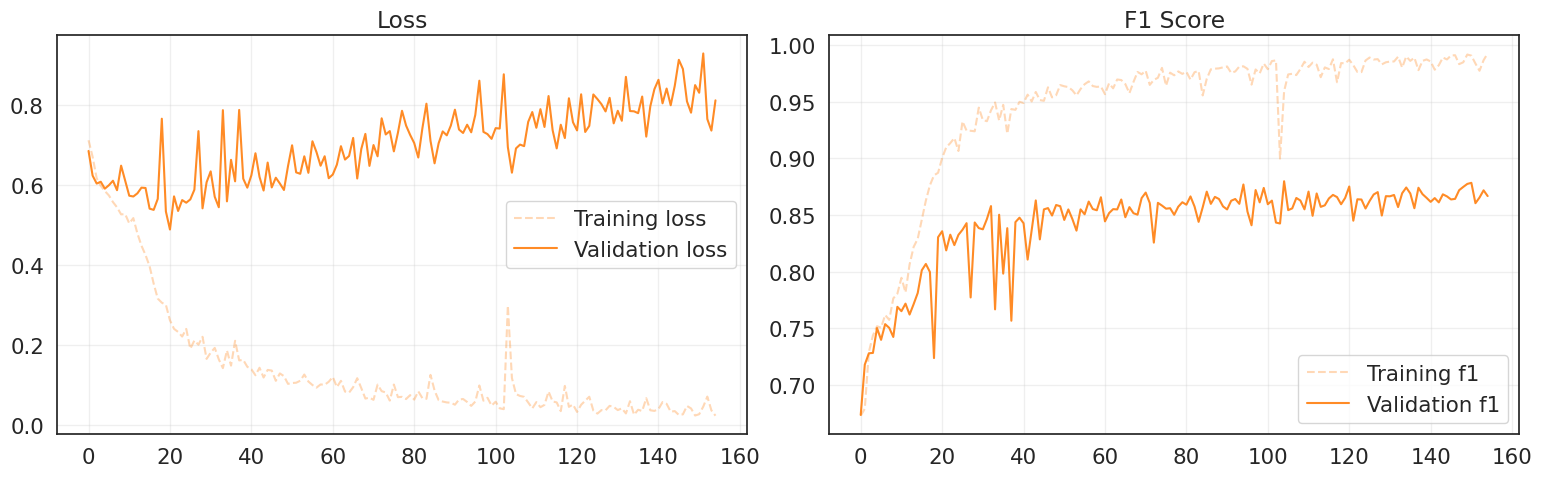

In [75]:
# @title History
# Create a figure with two side-by-side subplots (two columns)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 5))

# Plot of training and validation loss on the first axis
ax1.plot(training_history['train_loss'], label='Training loss', alpha=0.3, color='#ff7f0e', linestyle='--')
ax1.plot(training_history['val_loss'], label='Validation loss', alpha=0.9, color='#ff7f0e')
ax1.set_title('Loss')
ax1.legend()
ax1.grid(alpha=0.3)

# Plot of training and validation accuracy on the second axis
ax2.plot(training_history['train_f1'], label='Training f1', alpha=0.3, color='#ff7f0e', linestyle='--')
ax2.plot(training_history['val_f1'], label='Validation f1', alpha=0.9, color='#ff7f0e')
ax2.set_title('F1 Score')
ax2.legend()
ax2.grid(alpha=0.3)

# Adjust the layout and display the plot
plt.tight_layout()
plt.subplots_adjust(right=0.85)
plt.show()

Accuracy over the validation set: 0.8854
Precision over the validation set: 0.8786
Recall over the validation set: 0.8854
F1 score over the validation set: 0.8797


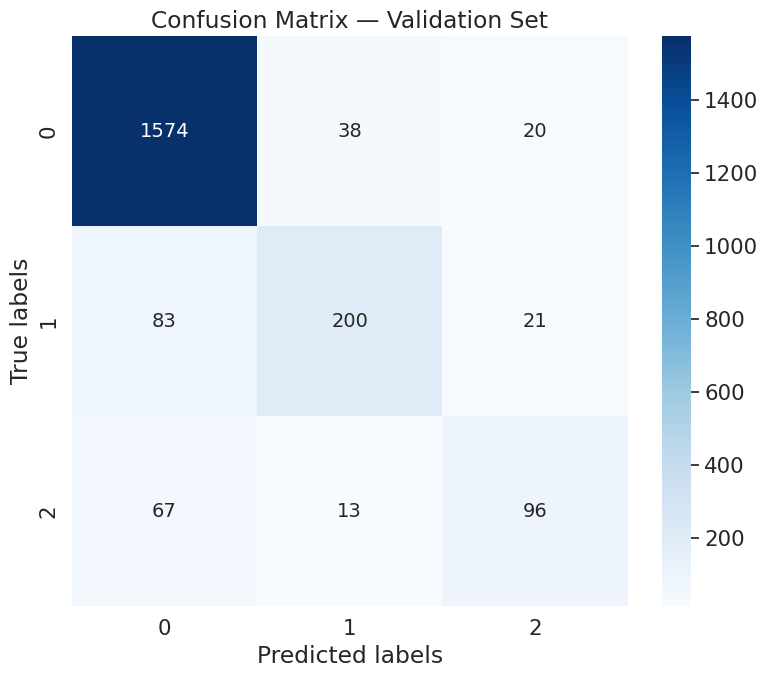

In [76]:
# @title Confusion Matrix
# Collect predictions and ground truth labels
val_preds, val_targets = [], []
with torch.no_grad():  # Disable gradient computation for inference
    for xb, yb in val_loader:
        xb = xb.to(device)

        # Forward pass: get model predictions
        logits = trained_model(xb)
        preds = logits.argmax(dim=1).cpu().numpy()

        # Store batch results
        val_preds.append(preds)
        val_targets.append(yb.numpy())

# Combine all batches into single arrays
val_preds = np.concatenate(val_preds)
val_targets = np.concatenate(val_targets)

# Calculate overall validation metrics
val_acc = accuracy_score(val_targets, val_preds)
val_prec = precision_score(val_targets, val_preds, average='weighted')
val_rec = recall_score(val_targets, val_preds, average='weighted')
val_f1 = f1_score(val_targets, val_preds, average='weighted')
print(f"Accuracy over the validation set: {val_acc:.4f}")
print(f"Precision over the validation set: {val_prec:.4f}")
print(f"Recall over the validation set: {val_rec:.4f}")
print(f"F1 score over the validation set: {val_f1:.4f}")

# Generate confusion matrix for detailed error analysis
cm = confusion_matrix(val_targets, val_preds)

# Create numeric labels for heatmap annotation
labels = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)

# Visualise confusion matrix
plt.figure(figsize=(8, 7))
sns.heatmap(cm, annot=labels, fmt='',
            cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix — Validation Set')
plt.tight_layout()
plt.show()

##🔍 **Grid Search**

###**Functions**

In [ ]:
def grid_search_cv_rnn(model, df, param_grid, fixed_params, cv_params, verbose=True):
    """
    Execute grid search with K-shuffle-split cross-validation for RNN models on time series data.

    Args:
        df: DataFrame with columns ['user_id', 'activity', 'x_axis', 'y_axis', 'z_axis', 'id']
        param_grid: Dict of parameters to test, e.g. {'batch_size': [16, 32], 'rnn_type': ['LSTM', 'GRU']}
        fixed_params: Dict of fixed hyperparameters (hidden_size, learning_rate, window_size, stride, etc.)
        cv_params: Dict of CV settings (epochs, k, patience, criterion, scaler, device, etc.)
        verbose: Print progress for each configuration

    Returns:
        results: Dict with scores for each configuration
        best_config: Dict with best hyperparameter combination
        best_score: Best mean F1 score achieved
    """
    # Generate all parameter combinations
    param_names = list(param_grid.keys())
    param_values = list(param_grid.values())
    combinations = list(product(*param_values))

    results = {}
    best_score = -np.inf
    best_config = None

    total = len(combinations)

    for idx, combo in enumerate(combinations, 1):
        # Create current configuration dict
        current_config = dict(zip(param_names, combo))
        config_str = "_".join([f"{k}_{v}" for k, v in current_config.items()])

        if verbose:
            print(f"\nConfiguration {idx}/{total}:")
            for param, value in current_config.items():
                print(f"  {param}: {value}")

        # Merge current config with fixed parameters
        run_params = {**fixed_params, **current_config}

        # Execute cross-validation
        _, _, fold_scores = k_shuffle_split_cross_validation_round_rnn(
            model=model,
            df=df,
            experiment_name=config_str,
            **run_params,
            **cv_params
        )

        # Store results
        results[config_str] = fold_scores

        # Track best configuration
        if fold_scores["mean"] > best_score:
            best_score = fold_scores["mean"]
            best_config = current_config.copy()
            if verbose:
                print("  NEW BEST SCORE!")

        if verbose:
            print(f"  F1 Score: {fold_scores['mean']:.4f}±{fold_scores['std']:.4f}")

    return results, best_config, best_score

In [ ]:
def plot_top_configurations_rnn(results, k_splits, top_n=5, figsize=(14, 7)):
    """
    Visualise top N RNN configurations with boxplots of F1 scores across CV splits.

    Args:
        results: Dict of results from grid_search_cv_rnn
        k_splits: Number of CV splits used
        top_n: Number of top configurations to display
        figsize: Figure size tuple
    """
    # Sort by mean score
    config_scores = {name: data['mean'] for name, data in results.items()}
    sorted_configs = sorted(config_scores.items(), key=lambda x: x[1], reverse=True)

    # Select top N
    top_configs = sorted_configs[:min(top_n, len(sorted_configs))]

    # Prepare boxplot data
    boxplot_data = []
    labels = []

    # Define a dictionary for replacements, ordered to handle prefixes correctly
    replacements = {
        'batch_size_': 'BS=',
        'learning_rate_': '\nLR=',
        'hidden_layers_': '\nHL=',
        'hidden_size_': '\nHS=',
        'dropout_rate_': '\nDR=',
        'window_size_': '\nWS=',
        'stride_': '\nSTR=',
        'rnn_type_': '\nRNN=',
        'bidirectional_': '\nBIDIR=',
        'l1_lambda_': '\nL1=',
        'l2_lambda_': '\nL2='
    }

    # Replacements for separators
    separator_replacements = {
        '_learning_rate_': '\nLR=',
        '_hidden_layers_': '\nHL=',
        '_hidden_size_': '\nHS=',
        '_dropout_rate_': '\nDR=',
        '_window_size_': '\nWS=',
        '_stride_': '\nSTR=',
        '_rnn_type_': '\nRNN=',
        '_bidirectional_': '\nBIDIR=',
        '_l1_lambda_': '\nL1=',
        '_l2_lambda_': '\nL2=',
        '_': ''
    }

    for config_name, mean_score in top_configs:
        # Extract best score from each split (auto-detect number of splits)
        split_scores = []
        for i in range(k_splits):
            if f'split_{i}' in results[config_name]:
                split_scores.append(results[config_name][f'split_{i}'])
        boxplot_data.append(split_scores)

        # Verify we have the expected number of splits
        if len(split_scores) != k_splits:
            print(f"Warning: Config {config_name} has {len(split_scores)} splits, expected {k_splits}")

        # Create readable label using the replacements dictionary
        readable_label = config_name
        for old, new in replacements.items():
            readable_label = readable_label.replace(old, new)

        # Apply separator replacements
        for old, new in separator_replacements.items():
             readable_label = readable_label.replace(old, new)

        labels.append(f"{readable_label}\n(μ={mean_score:.3f})")

    # Create plot
    fig, ax = plt.subplots(figsize=figsize)
    bp = ax.boxplot(boxplot_data, labels=labels, patch_artist=True,
                    showmeans=True, meanline=True)

    # Styling
    for patch in bp['boxes']:
        patch.set_facecolor('lightblue')
        patch.set_alpha(0.7)

    # Highlight best configuration
    ax.get_xticklabels()[0].set_fontweight('bold')

    ax.set_ylabel('F1 Score')
    ax.set_xlabel('Configuration')
    ax.set_title(f'Top {len(top_configs)} RNN Configurations - F1 Score Distribution Across {k_splits} Splits')
    ax.grid(alpha=0.3, axis='y')

    plt.xticks(rotation=0, ha='center')
    plt.tight_layout()
    plt.show()

###**Search!**

In [ ]:
%%time
# Define parameters to search
param_grid = {
    'window_size': [20, 40],
}

# Fixed hyperparameters (not being tuned)
fixed_params = {
    'learning_rate': LEARNING_RATE,
    'hidden_layers': HIDDEN_LAYERS,
    'hidden_size': HIDDEN_SIZE,
    'l1_lambda': L1_LAMBDA,
    'l2_lambda': L2_LAMBDA,
    'stride': STRIDE,
    'batch_size': BATCH_SIZE,
    'bidirectional':  BIDIRECTIONAL,
    'dropout_rate': DROPOUT_RATE,
    'rnn_type': RNN_TYPE,
}

# Cross-validation settings
cv_params = {
    'epochs': EPOCHS,
    'criterion': criterion,
    'device': device,
    'k': K,
    'val_percent': VAL_PERCENT,
    'test_percent': TEST_PERCENT,
    'patience': PATIENCE,
    'verbose': 0,
    'seed': SEED
}

# Execute search
results, best_config, best_score = grid_search_cv_rnn(
    model=model,
    df=df,
    param_grid=param_grid,
    fixed_params=fixed_params,
    cv_params=cv_params
)


Configuration 1/2:
  window_size: 20
Training 500 epochs...
Early stopping triggered after 154 epochs.
Best model restored from epoch 104 with val_f1 0.8670
  NEW BEST SCORE!
  F1 Score: 0.8670±0.0000

Configuration 2/2:
  window_size: 40
Training 500 epochs...
Early stopping triggered after 153 epochs.
Best model restored from epoch 103 with val_f1 0.8419
  F1 Score: 0.8419±0.0000
CPU times: user 1min 2s, sys: 1min 19s, total: 2min 21s
Wall time: 4min 9s


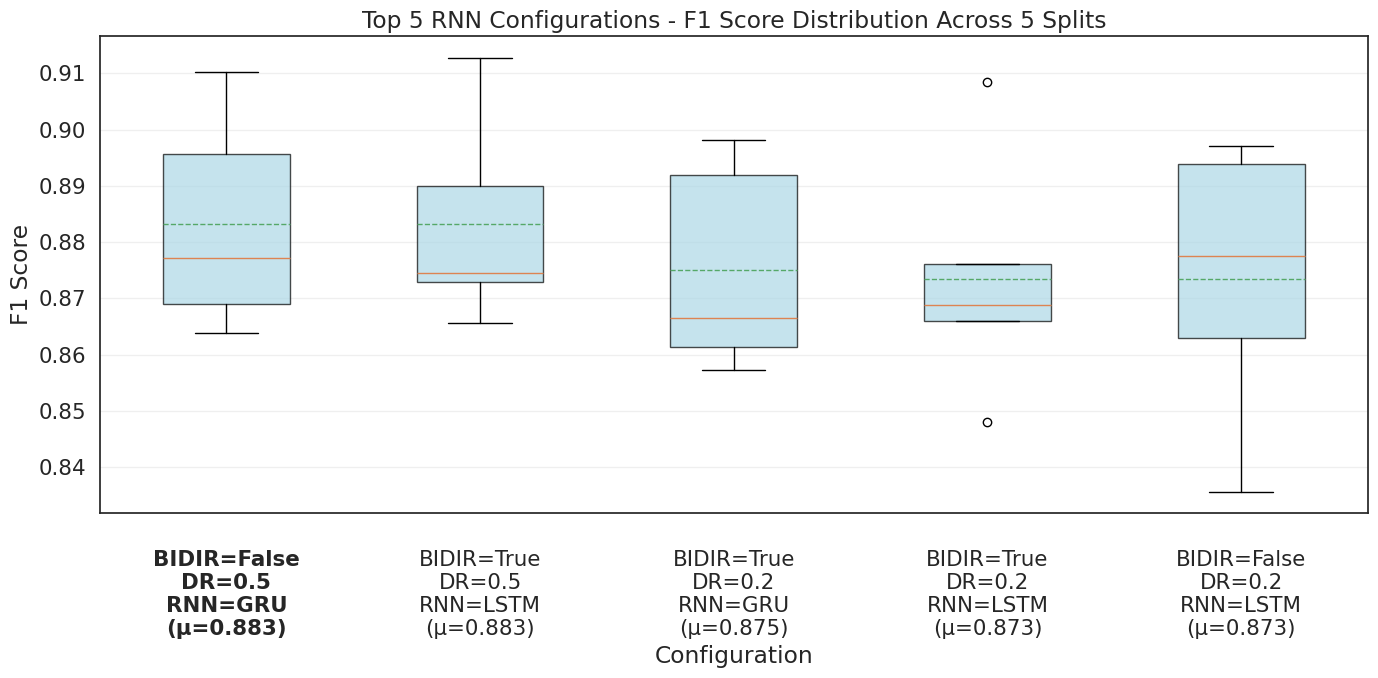

In [ ]:
# Plot results
plot_top_configurations_rnn(results, k_splits=K, top_n=5)

##🚩 **Final Training!**

###**Setup**

In [77]:
def fit_final_full_dataset(model, train_loader, epochs, criterion, optimizer, scaler, device,
                           l1_lambda=0, l2_lambda=0, writer=None, verbose=10, experiment_name=""):
    """
    Train the neural network model on the entire dataset without validation.

    Args:
        model (nn.Module): The neural network model to train
        train_loader (DataLoader): PyTorch DataLoader containing all data
        epochs (int): Number of training epochs
        criterion (nn.Module): Loss function (e.g., CrossEntropyLoss, MSELoss)
        optimizer (torch.optim): Optimization algorithm (e.g., Adam, SGD)
        scaler (GradScaler): PyTorch's gradient scaler for mixed precision training
        device (torch.device): Computing device ('cuda' or 'cpu')
        l1_lambda (float): L1 regularization coefficient (default: 0)
        l2_lambda (float): L2 regularization coefficient (default: 0)
        writer (SummaryWriter, optional): TensorBoard SummaryWriter object for logging (default: None)
        verbose (int, optional): Frequency of printing training progress (default: 10)
        experiment_name (str, optional): Experiment name for saving the model (default: "")

    Returns:
        tuple: (model, training_history) - Trained model and metrics history
    """

    training_history = {'train_loss': [], 'train_f1': []}

    print(f"Training {epochs} epochs on the full dataset...")

    for epoch in range(1, epochs + 1):
        # Train one epoch
        train_loss, train_f1 = train_one_epoch(
            model, train_loader, criterion, optimizer, scaler, device, l1_lambda, l2_lambda
        )

        # Store metrics
        training_history['train_loss'].append(train_loss)
        training_history['train_f1'].append(train_f1)

        # Print progress
        if verbose > 0 and (epoch % verbose == 0 or epoch == 1):
            print(f"Epoch {epoch:3d}/{epochs} | Train: Loss={train_loss:.4f}, F1 Score={train_f1:.4f}")

    print("Final training completed!")
    return model, training_history


In [78]:
# Create final model

# Initialise model architecture
final_model = build_model_with_curr_params(features=features, df=df)

# Set model in training mode
final_model.train()

# Define dataframe
df_final_train = df_final_train

# Build sequences using entire dataset
X_train, y_train = build_sequences(df_final_train, window=WINDOW_SIZE, stride=STRIDE)

# Create PyTorch datasets
final_train_ds = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train))

# Create loaders
train_loader = make_loader(final_train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)

# Don't use Tensorboard
writer = None

# Define optimizer and scaler
optimizer = torch.optim.AdamW(final_model.parameters(), lr=LEARNING_RATE, weight_decay=L2_LAMBDA)
scaler = torch.cuda.amp.GradScaler(enabled=(device.type == 'cuda'))

# Define criterion
if(WEIGHTED_LOSS):
  class_weights = get_class_weights(df_final_train)
  criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
else:
  criterion = nn.CrossEntropyLoss()

# Define epochs number for early stopping
stop_after_epochs = best_epoch + EPOCHS_VARIATION

###**Train!**

In [79]:
if(not FINAL_TRAINING):
  raise SystemExit("Hai disattivato il final training!")

trained_model, final_training_history = fit_final_full_dataset(
    model=final_model,
    train_loader=train_loader,
    epochs=stop_after_epochs,
    criterion=criterion,
    optimizer=optimizer,
    scaler=scaler,
    device=device,
    l1_lambda=L1_LAMBDA,
    l2_lambda=L2_LAMBDA,
    writer=writer,
    verbose=VERBOSE,
    experiment_name=EXPERIMENT_NAME
)

Training 115 epochs on the full dataset...
Epoch   1/115 | Train: Loss=4.0029, F1 Score=0.6725
Epoch  10/115 | Train: Loss=0.7281, F1 Score=0.6741
Epoch  20/115 | Train: Loss=0.7210, F1 Score=0.6741
Epoch  30/115 | Train: Loss=0.7184, F1 Score=0.6741
Epoch  40/115 | Train: Loss=0.7168, F1 Score=0.6741
Epoch  50/115 | Train: Loss=0.7154, F1 Score=0.6741
Epoch  60/115 | Train: Loss=0.7144, F1 Score=0.6741
Epoch  70/115 | Train: Loss=0.7132, F1 Score=0.6741
Epoch  80/115 | Train: Loss=0.7129, F1 Score=0.6741
Epoch  90/115 | Train: Loss=0.7122, F1 Score=0.6741
Epoch 100/115 | Train: Loss=0.7118, F1 Score=0.6741
Epoch 110/115 | Train: Loss=0.7119, F1 Score=0.6741
Final training completed!


##💾 **Save Model!**

In [83]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# 1. Definizione Percorsi e Nomi File
# Crea una cartella locale in /content
save_dir = "/content/drive/MyDrive/Artificial_Neural_Networks/Timeseries_Classification_Challenge/models"
os.makedirs(save_dir, exist_ok=True)

# Nome base del file (con timestamp per i pesi e per i parametri)
from datetime import datetime
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
file_name_base = f"{EXPERIMENT_NAME}_{timestamp}"

weights_file_name = f"{file_name_base}.pth"
params_file_name = f"{file_name_base}_params.txt"

# Percorsi completi
MODEL_PATH = os.path.join(save_dir, f"{file_name_base}.pth")
PARAMS_PATH = os.path.join(save_dir, f"{file_name_base}_params.txt")


# 2. Salvataggio dei Pesi del Modello
# Assumendo che 'trained_model' sia il tuo modello PyTorch addestrato
try:
    torch.save(trained_model.state_dict(), MODEL_PATH)
    print(f"✅ Pesi del modello salvati in: {MODEL_PATH}")
except NameError:
    print("⚠️ Attenzione: La variabile 'trained_model' non è definita. I pesi non sono stati salvati.")
except Exception as e:
    print(f"❌ Errore durante il salvataggio dei pesi: {e}")


# 3. Salvataggio del File di Testo dei Parametri
with open(PARAMS_PATH, 'w') as f:
    f.write(f"--- PARAMETRI ESPERIMENTO: {EXPERIMENT_NAME} ---\n")
    f.write(f"Timestamp: {timestamp}\n")
    f.write(f"Percorso File Pesi (PTH): {MODEL_PATH}\n\n")

    # PREPROCESSING FLAGS
    f.write("--- PREPROCESSING E SCALING ---\n")
    f.write(f"NORMAL_VALIDATION: {NORMAL_VALIDATION}\n")
    f.write(f"K_FOLD: {K_FOLD}\n")
    f.write(f"CLIP_LOG: {CLIP_LOG}\n")
    f.write(f"MIN_MAX (Scaling): {MIN_MAX}\n")
    f.write(f"ROBUST_SCALER: {ROBUST_SCALER}\n")
    f.write(f"DROP_HIGHLY_CORRELATED: {DROP_HIGHLY_CORRELATED}\n")
    f.write(f"CORRELATION_THRESHOLD: {CORRELATION_THRESHOLD}\n\n")

    # CROSS-VALIDATION & SPLITTING
    f.write("--- SUDDIVISIONE DATI ---\n")
    f.write(f"K (Splits, se K_FOLD=True): {K}\n")
    f.write(f"VAL_PERCENT: {VAL_PERCENT}\n")
    f.write(f"TEST_PERCENT: {TEST_PERCENT}\n\n")

    # OPTIMISATION & WINDOWING
    f.write("--- OTTIMIZZAZIONE E INPUT ---\n")
    f.write(f"LEARNING_RATE: {LEARNING_RATE}\n")
    f.write(f"BATCH_SIZE: {BATCH_SIZE}\n")
    f.write(f"WINDOW_SIZE: {WINDOW_SIZE}\n")
    f.write(f"STRIDE: {STRIDE}\n\n")

    # ARCHITECTURE
    f.write("--- ARCHITETTURA RNN ---\n")
    f.write(f"RNN_TYPE: {RNN_TYPE}\n")
    f.write(f"HIDDEN_LAYERS: {HIDDEN_LAYERS}\n")
    f.write(f"HIDDEN_SIZE (Neuroni): {HIDDEN_SIZE}\n")
    f.write(f"BIDIRECTIONAL: {BIDIRECTIONAL}\n\n")

    # REGULARISATION
    f.write("--- REGOLARIZZAZIONE ---\n")
    f.write(f"DROPOUT_RATE: {DROPOUT_RATE}\n")
    f.write(f"L1_LAMBDA: {L1_LAMBDA}\n")
    f.write(f"L2_LAMBDA: {L2_LAMBDA}\n\n")

    # TRAINING METRICS
    f.write("--- ADDESTRAMENTO ---\n")
    f.write(f"EPOCHS (Max): {EPOCHS}\n")
    f.write(f"PATIENCE (Early Stopping): {PATIENCE}\n")
    f.write(f"VERBOSE (Print Freq): {VERBOSE}\n")
    f.write(f"WEIGHTED_LOSS: {WEIGHTED_LOSS}\n")
    f.write(f"EPOCHS_VARIATION: {EPOCHS_VARIATION}\n\n")

    # FINAL RESULTS (Esempio)
    # f.write("--- RISULTATI FINALI ---\n")
    # f.write(f"ACCURACY_SCORE (Esempio): {ACCURACY_SCORE}\n")
    # f.write(f"LOSS_VALUE (Esempio): {LOSS_VALUE}\n")

print(f"📝 Parametri salvati in: {PARAMS_PATH}")

# 4. Verifica dei File Salvati
print("\n--- Files salvati in Drive ---")
!ls -lh "$save_dir"

Mounted at /content/drive
✅ Pesi del modello salvati in: /content/drive/MyDrive/Artificial_Neural_Networks/Timeseries_Classification_Challenge/models/test_20251114_202225.pth
📝 Parametri salvati in: /content/drive/MyDrive/Artificial_Neural_Networks/Timeseries_Classification_Challenge/models/test_20251114_202225_params.txt

--- Files salvati in Drive ---
total 643K
-rw------- 1 root root  903 Nov 14 20:22 test_20251114_202225_params.txt
-rw------- 1 root root 642K Nov 14 20:22 test_20251114_202225.pth


In [ ]:
# @title Download (from drive)
try:
    files.download(MODEL_PATH)
    files.download(PARAMS_PATH)
    print(f"\n✅ Il file '{weights_file_name}' è stato scaricato nella tua cartella Download locale.")
    print(f"\n✅ Il file '{params_file_name}' è stato scaricato nella tua cartella Download locale.")
except Exception as e:
    print(f"\nErrore durante il download: {e}")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


✅ Il file 'test_20251113_192703.pth' è stato scaricato nella tua cartella Download locale.


## 🕹️ **Kaggle Inference**

In [84]:
# Do you want to test a different model?
# Insert the file-name here:
# [path must be: "/content/drive/MyDrive/Artificial_Neural_Networks/Timeseries_Classification_Challenge/models/"]
# [type also ".pth"]
model_file_name = None

# NOTE: remeber to insert the correct hyperparameters in the corresponding section

###**Preparation**

In [95]:
def build_sequences_inference(df: pd.DataFrame, features: List[str], window: int = 40, stride: int = 20) -> np.ndarray:
    """
    Costruisce sequenze (windows) da un DataFrame di test per la predizione (inference).
    Non richiede né processa alcuna colonna 'label'.

    Args:
        df (pd.DataFrame): Il DataFrame di test contenente dati temporali raggruppati per 'sample_index'.
        features (List[str]): Lista delle colonne delle feature da usare per le sequenze.
        window (int): Lunghezza della sequenza temporale (dimensione della finestra).
        stride (int): Passo con cui la finestra si muove (sovrapposizione).

    Returns:
        np.ndarray: Array NumPy 3D contenente le sequenze [num_sequences, window, num_features].
    """
    print(f"--- Inizio preparazione sequenze (Window: {window}, Stride: {stride}) ---")

    # Sanity check
    assert window % stride == 0

    # Lista per contenere le sequenze (dataset)
    dataset = []
    indices = []  # keep sample_index to know who is who

    # Iterate over unique IDs in the DataFrame
    for id in df['sample_index'].unique():
        # Sort values based on time for the current ID
        temp_df = df[df['sample_index'] == id].sort_values('time')

        # Estraggo solo i valori delle feature
        temp = temp_df[features].values

        # Calculate padding length to ensure full windows
        padding_len = (window - len(temp) % window) % window

        # Create zero padding and concatenate with the data
        padding = np.zeros((padding_len, len(features)), dtype='float32')
        temp = np.concatenate((temp, padding))

        # Build feature windows
        idx = 0
        while idx + window <= len(temp):
            dataset.append(temp[idx:idx + window])
            indices.append(id)
            idx += stride

    # Convert lists to numpy array for further processing
    dataset = np.array(dataset)
    indices = np.array(indices)

    # Ritorna solo le sequenze
    return dataset, indices

In [96]:
# Recreate model and load weights
best_model_path = "/content/drive/MyDrive/Artificial_Neural_Networks/Timeseries_Classification_Challenge/models/"+weights_file_name

model_for_inference = build_model_with_curr_params(features, df)

model_for_inference.load_state_dict(torch.load(best_model_path, map_location=device))
model_for_inference.eval()
print("✅ Model loaded for inference.")


✅ Model loaded for inference.


In [97]:
X_test, test_indices = build_sequences_inference(df_test, features=features, window=WINDOW_SIZE, stride=STRIDE)

# Convert test windows to TensorLoader
test_ds = TensorDataset(torch.from_numpy(X_test).float())
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

--- Inizio preparazione sequenze (Window: 30, Stride: 10) ---


###**Test!**

In [98]:
# @title Execute test

# Collect predictions
all_preds = []

with torch.no_grad():
    for (xb,) in test_loader:
        xb = xb.to(device)
        logits = model_for_inference(xb)
        preds = logits.argmax(dim=1)
        all_preds.append(preds.cpu().numpy())

all_preds = np.concatenate(all_preds)


In [99]:
# @title Save .csv

# Combine window predictions per subject
pred_df = pd.DataFrame({'sample_index': test_indices, 'pred': all_preds})

# Aggregate by majority vote
final_preds = (
    pred_df.groupby('sample_index')['pred']
    .agg(lambda x: np.bincount(x).argmax())  # most frequent label
    .reset_index()
)

# Map back to label names
inv_label_map = {v: k for k, v in label_mapping.items()}
final_preds['label'] = final_preds['pred'].map(inv_label_map)

# Sort by sample_index just in case
final_preds = final_preds.sort_values(by='sample_index')

# Keep only required columns
submission = final_preds[['sample_index', 'label']]

# Save in Kaggle submission format
submission_path = "/kaggle/working/submission.csv"  # for Kaggle
# Or to your Drive:
submission_path = "/content/drive/MyDrive/Artificial_Neural_Networks/Timeseries_Classification_Challenge/submission.csv"

submission.to_csv(submission_path, index=False)
print(f"✅ Submission file saved at: {submission_path}")
print(submission.head())


✅ Submission file saved at: /content/drive/MyDrive/Artificial_Neural_Networks/Timeseries_Classification_Challenge/submission.csv
   sample_index    label
0             0  no_pain
1             1  no_pain
2             2  no_pain
3             3  no_pain
4             4  no_pain
